In [259]:
%load_ext autoreload
%autoreload 2
import numpy as np
from DE_library import simulate_ODE, simulate_phase_portrait
import matplotlib.pyplot as plt

import sys
from MARBLE import utils, geometry, net, plotting

rng = np.random.RandomState(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Bogdanov-Takens system http://www.scholarpedia.org/article/Bogdanov-Takens_bifurcation

# For initial conditions, sample the $[-1,1]^2$ rectangle uniformly

In [281]:
t0, t1, dt = 0, 3, 0.5
t = np.arange(t0, t1, dt)
n = 100

X0_range = [geometry.sample_2d(n, [[-1,-1],[1,1]], 'uniform') for i in range(4)]

# Display state spaces under four different parameter conditions

In [286]:
def simulate_system(mu, X0_range):
    pos, vel = simulate_phase_portrait('vanderpol', t, X0_range, par = {'mu': mu})
    return pos, vel

def plot_phase_portrait(pos, vel, ax, style='>', arrow_spacing=1):

    for p, v in zip(pos, vel):
        ax = plotting.trajectories(p, v, ax=ax, style=style, lw=1, arrowhead=.03, arrow_spacing=arrow_spacing, axis=False, alpha=None)
    ax.axis('square')
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])

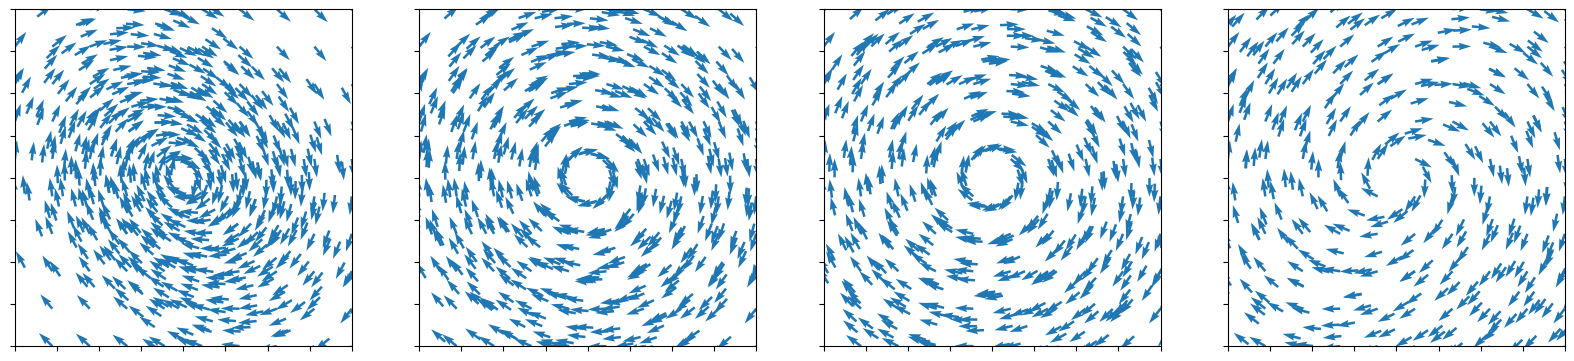

In [287]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
    
pos, vel = simulate_system(-0.5, X0_range[0])
plot_phase_portrait(pos, vel, ax[0])
pos, vel = simulate_system(-0.1, X0_range[1])
plot_phase_portrait(pos, vel, ax[1])
pos, vel = simulate_system(0.1, X0_range[2])
plot_phase_portrait(pos, vel, ax[2])
pos, vel = simulate_system(0.5, X0_range[3])
plot_phase_portrait(pos, vel, ax[3])

# Geneate phase portraits from random initial conditions while varying $\beta_1$

In [334]:
beta1 = np.linspace(-0.5,0.5,10)

pos, vel = [], []
for b1 in beta1:
    X0_range = geometry.sample_2d(n, [[-1,-1],[1,1]], 'uniform')
    p, v = simulate_system(b1, X0_range)
    p, v = np.vstack(p), np.vstack(v)
    ind = np.where((abs(p)<1).any(1))[0]
    v = v[ind,:]
    p = p[ind,:]
    
    pos.append(p)
    vel.append(v)

In [335]:
pos_subsample = pos
vel_subsample = vel
#ind = rng.permutation(len(beta1))
#pos_subsampl = [pos_subsample[i] for i in ind]
#vel_subsample = [vel_subsample[i] for i in ind]

# Subsample phase portrait

In [351]:
pos_subsample, vel_subsample = [], []
for i, (p,v) in enumerate(zip(pos,vel)):
    ind, _ = geometry.furthest_point_sampling(p, stop_crit=0.02)
    pos_subsample.append(p[ind])
    vel_subsample.append(v[ind])

Compare phase portraits before and after subsampling

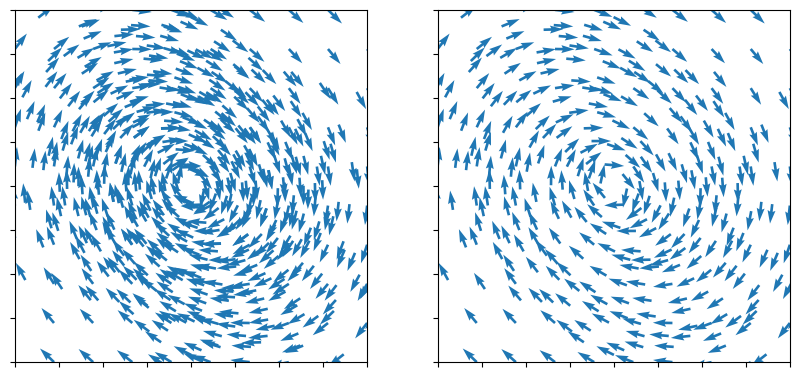

In [352]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

i=0
j=-1
#plot_phase_portrait([pos[j]], [vel[j]], ax[0], style='>', arrow_spacing=1)
plot_phase_portrait([pos[i]], [vel[i]], ax[0], style='>', arrow_spacing=1)
plot_phase_portrait([pos_subsample[i]], [vel_subsample[i]], ax[1], style='>', arrow_spacing=1)

# Train network

In [353]:
k=10

data = utils.construct_dataset(pos_subsample, features=vel_subsample, graph_type='cknn', k=k)

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

par = {'batch_size': 256, #batch size
       'epochs': 20, #optimisation epochs
       'order': 3, #order of derivatives
       'depth': 0, #number of hops in neighbourhood
       'n_lin_layers': 2,
       'hidden_channels': 16, #number of internal dimensions in MLP
       'out_channels': 4,
       'diffusion': False,
       'inner_product_features': True,
       'vector' : False
      }

model = net(data, gauge='global', **par)
model.run_training(data)

---- Settings: 

gauge : global
batch_size : 256
epochs : 20
order : 3
depth : 0
n_lin_layers : 2
hidden_channels : 16
out_channels : 4
diffusion : False
inner_product_features : True
vector : False
frac_geodesic_nb : 2.0
var_explained : 0.9
frac_sampled_nb : 0.8
dropout : 0.0
bias : False
batch_norm : batch_norm
lr : 0.01
seed : 0
signal_dim : 2
emb_dim : 2
n_sampled_nb : 8
n_geodesic_nb : 20
dim_embedding : 2

---- Number of features to pass to the MLP:  15
---- Total number of parameters:  397
---- Treating features as scalar channels.

---- Starting training ... 

Epoch: 1, Training loss: 15.4413, Validation loss: 21.7202
Epoch: 2, Training loss: 14.9074, Validation loss: 20.9588
Epoch: 3, Training loss: 14.6794, Validation loss: 20.3780
Epoch: 4, Training loss: 14.5956, Validation loss: 20.4315
Epoch: 5, Training loss: 14.4471, Validation loss: 19.3724
Epoch: 6, Training loss: 14.4990, Validation loss: 20.0082
Epoch: 7, Training loss: 14.2929, Validation loss: 19.2343
Epoch: 8, Tr

# Create embeddings and cluster

In [363]:
n_clusters = 40
data = model.evaluate(data)

# Visualise embedding

Performed UMAP embedding on embedded results.


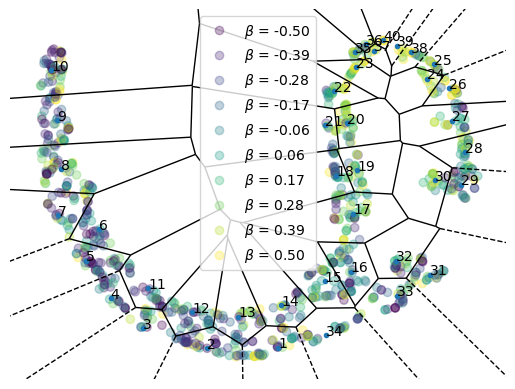

In [364]:
tsne_emb, clusters, dist = geometry.cluster_embedding(data, n_clusters=n_clusters, embed_typ='umap')
titles = [r'$\beta$ = {:0.2f}'.format(b) for b in beta1]
plotting.embedding(tsne_emb, data.y.numpy(), clusters, titles=titles)

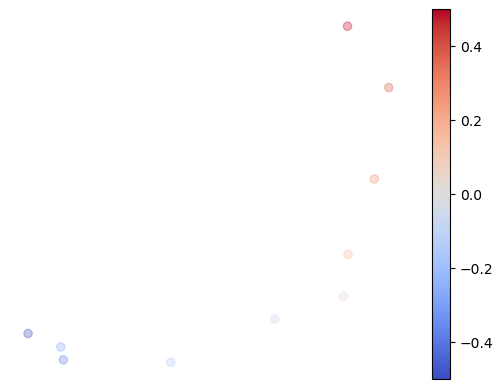

In [376]:
emb_MDS = geometry.embed(dist, embed_typ = 'MDS')
plotting.embedding(emb_MDS, beta1)

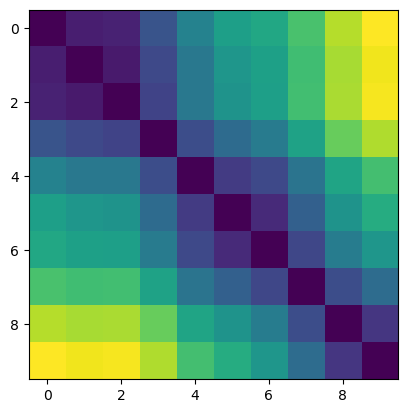

In [377]:
plt.imshow(dist)

In [236]:
dist = geometry.compute_distribution_distances(data)